In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import datetime as dt
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, learning_curve 
from sklearn.metrics import recall_score,cohen_kappa_score,roc_curve, auc,accuracy_score,confusion_matrix,f1_score,precision_score,roc_auc_score,roc_curve
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import lightgbm as lgb

Train = pd.read_csv("exoTrain.csv",sep=',')
Test = pd.read_csv("exoTest.csv",sep=',')

print(Train.shape)
print(Test.shape)

(5087, 3198)
(570, 3198)


In [2]:
X_train = Train.drop('LABEL', axis=1).values
X_test = Test.drop('LABEL', axis=1).values
y_train = Train['LABEL'].values
y_test = Test['LABEL'].values



In [3]:
pca = PCA(.95)

pca.fit(X_train)

print('Cumulative explained variation: {}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation: 0.9608131841414359


In [4]:
pca.n_components_

8

In [5]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

In [6]:
# Use Sklearn to create Model and train model 

print('Start training...')
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=20,learning_rate=0.05,n_estimators=20)
gbm.fit(X_train_pca, y_train,eval_set=[(X_test_pca, y_test)],eval_metric='l1',early_stopping_rounds=5)


Start training...
[1]	valid_0's l1: 0.0158886	valid_0's l2: 0.00869551
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.0158239	valid_0's l2: 0.0086879
[3]	valid_0's l1: 0.01584	valid_0's l2: 0.00866397
[4]	valid_0's l1: 0.0158361	valid_0's l2: 0.00866287
[5]	valid_0's l1: 0.0157671	valid_0's l2: 0.00862312
[6]	valid_0's l1: 0.0157265	valid_0's l2: 0.00860962
[7]	valid_0's l1: 0.0157338	valid_0's l2: 0.00859846
[8]	valid_0's l1: 0.0157471	valid_0's l2: 0.00860626
[9]	valid_0's l1: 0.0157942	valid_0's l2: 0.00860122
[10]	valid_0's l1: 0.0157481	valid_0's l2: 0.00860576
[11]	valid_0's l1: 0.0156896	valid_0's l2: 0.00857595
[12]	valid_0's l1: 0.0156934	valid_0's l2: 0.0085605
[13]	valid_0's l1: 0.0157389	valid_0's l2: 0.00852722
[14]	valid_0's l1: 0.0157632	valid_0's l2: 0.00851606
[15]	valid_0's l1: 0.0157378	valid_0's l2: 0.00850577
[16]	valid_0's l1: 0.0157736	valid_0's l2: 0.00849431
Early stopping, best iteration is:
[11]	valid_0's l1: 0.0156896	valid_0

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=20, n_jobs=-1, num_leaves=20, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [7]:
print('Start predicting...')
y_pred = gbm.predict(X_test_pca, num_iteration=gbm.best_iteration_)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Start predicting...
The rmse of prediction is: 0.0926063997711575


In [8]:
gbmModel = lgb.LGBMClassifier()
gbmModel.fit(X_train_pca,y_train)
y_pred = gbmModel.predict(X_test_pca)
print("Accuracy Score:",round(metrics.accuracy_score(y_test,y_pred) *100,2), '%')
print("ROC AUC:",metrics.roc_auc_score(y_test,y_pred))

Accuracy Score: 99.12 %
ROC AUC: 0.5


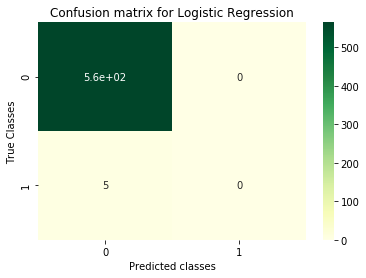

In [9]:
plt.title('Confusion matrix for Logistic Regression')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

In [10]:
# Use LGB.train()
# Convert the training data into LightGBM dataset formate 
# manually build python dictionary with lgb parameters 

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)




In [11]:
# Use the following parameters vavlue for faster result

params = {
 'task': 'train',
 
 'objective': 'regression', 
 'max_bin': 255, 
 'num_leaves': 31, 
 'learning_rate': 0.05, 
 'feature_fraction': 0.9, 
 'bagging_fraction': 0.8, 
 'bagging_freq': 5,
 
}

print('Start training...')

gbm = lgb.train(params,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=10)

Start training...
[1]	valid_0's l2: 0.00864193
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.00859433
[3]	valid_0's l2: 0.00855363
[4]	valid_0's l2: 0.00851146
[5]	valid_0's l2: 0.00847676
[6]	valid_0's l2: 0.00839803
[7]	valid_0's l2: 0.00838171
[8]	valid_0's l2: 0.0083984
[9]	valid_0's l2: 0.00833071
[10]	valid_0's l2: 0.00833881
[11]	valid_0's l2: 0.00832309
[12]	valid_0's l2: 0.00825376
[13]	valid_0's l2: 0.00820884
[14]	valid_0's l2: 0.00818334
[15]	valid_0's l2: 0.00813607
[16]	valid_0's l2: 0.00814411
[17]	valid_0's l2: 0.00816093
[18]	valid_0's l2: 0.00816681
[19]	valid_0's l2: 0.00818275
[20]	valid_0's l2: 0.00815848
Did not meet early stopping. Best iteration is:
[15]	valid_0's l2: 0.00813607


In [12]:
yy_pred = gbm.predict(X_test)

accuracy=accuracy_score(yy_pred.round(),y_test)

print('The rmse of prediction is:', mean_squared_error(y_test, yy_pred) ** 0.5)

print("Accuracy Score:",round(accuracy*100 , 2), '%')
print("ROC AUC:",metrics.roc_auc_score(y_test,yy_pred))

The rmse of prediction is: 0.0902001393528733
Accuracy Score: 99.12 %
ROC AUC: 0.6176991150442478


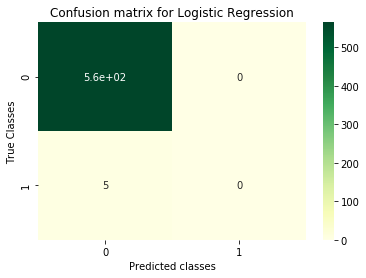

In [13]:
plt.title('Confusion matrix for Logistic Regression')
sns.heatmap(confusion_matrix(y_test, yy_pred.round()), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

In [14]:
# Use the following parameters vavlue for better accuracy
params2 = {
 'task': 'train',
 'objective': 'regression', 
 'num_leaves': 30, 
 'learning_rate': 0.03, 
 'feature_fraction': 0.9, 
 'num_iterations': 200, 
}

print('Start training...')

gbm2 = lgb.train(params2,lgb_train,num_boost_round=20,valid_sets=lgb_eval,early_stopping_rounds=10)

Start training...


D:\Installation\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l2: 0.00866555
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 0.0086384
[3]	valid_0's l2: 0.00862152
[4]	valid_0's l2: 0.00860607
[5]	valid_0's l2: 0.00851235
[6]	valid_0's l2: 0.0085011
[7]	valid_0's l2: 0.00847814
[8]	valid_0's l2: 0.00846632
[9]	valid_0's l2: 0.00842434
[10]	valid_0's l2: 0.00841649
[11]	valid_0's l2: 0.00837429
[12]	valid_0's l2: 0.0083706
[13]	valid_0's l2: 0.00832584
[14]	valid_0's l2: 0.0083157
[15]	valid_0's l2: 0.00827544
[16]	valid_0's l2: 0.0082652
[17]	valid_0's l2: 0.00826949
[18]	valid_0's l2: 0.00823363
[19]	valid_0's l2: 0.00822977
[20]	valid_0's l2: 0.00820475
[21]	valid_0's l2: 0.00820032
[22]	valid_0's l2: 0.00817577
[23]	valid_0's l2: 0.00816015
[24]	valid_0's l2: 0.00815121
[25]	valid_0's l2: 0.0081291
[26]	valid_0's l2: 0.00812692
[27]	valid_0's l2: 0.00811532
[28]	valid_0's l2: 0.00811344
[29]	valid_0's l2: 0.00810111
[30]	valid_0's l2: 0.00807545
[31]	valid_0's l2: 0.00808153
[32]	valid_0's l2: 0.008

In [15]:
yyy_pred = gbm2.predict(X_test)

accuracy=accuracy_score(yyy_pred.round(),y_test)

print('The rmse of prediction is:', mean_squared_error(y_test, yyy_pred) ** 0.5)

print("Accuracy Score:",round(accuracy*100 , 2), '%')
print("ROC AUC:",metrics.roc_auc_score(y_test,yyy_pred))

The rmse of prediction is: 0.08933316411140678
Accuracy Score: 99.12 %
ROC AUC: 0.9122123893805311


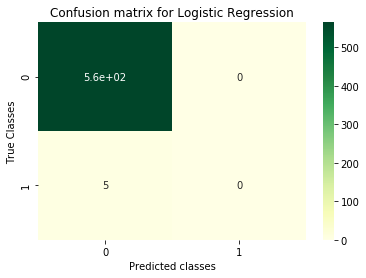

In [16]:
plt.title('Confusion matrix for Logistic Regression')
sns.heatmap(confusion_matrix(y_test, yy_pred.round()), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

In [21]:
data_train = lgb.Dataset(X_train, y_train)
cv_results = lgb.cv(params, data_train, num_boost_round=50, nfold=5, stratified=False, shuffle=True, metrics='auc',early_stopping_rounds=10,seed=0)
print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

best n_estimators: 1
best cv score: 1.0
